In [60]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline

In [3]:
df = pd.read_csv('kl.csv')
df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31.0,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94.0,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,�226.5M
1,1,20801,Cristiano Ronaldo,33.0,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94.0,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,�127.1M
2,2,190871,Neymar Jr,26.0,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92.0,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,�228.1M
3,3,193080,De Gea,27.0,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91.0,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,�138.6M
4,4,192985,K. De Bruyne,27.0,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91.0,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,�196.4M


In [4]:
df.shape

(18207, 89)

In [5]:
df.isnull().mean()

Unnamed: 0        0.000000
ID                0.000000
Name              0.000000
Age               0.000055
Photo             0.000000
                    ...   
GKHandling        0.002636
GKKicking         0.002636
GKPositioning     0.002636
GKReflexes        0.002636
Release Clause    0.085901
Length: 89, dtype: float64

<AxesSubplot:>

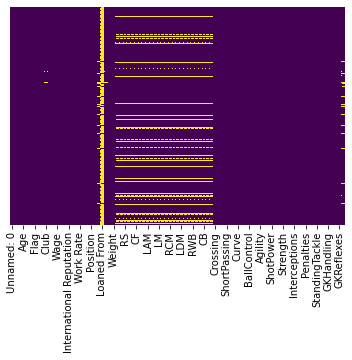

In [6]:
sns.heatmap(df.isna(), cmap='viridis', yticklabels=False, cbar=None)

In [7]:
def missing_values_boundry(df, missing_percentige):
    
    columns_with_missing_values_above_border = []
    series = df.isna().mean()
#     print(series)
    for index in series.index:
#         print(type(float(series[index])))
        if series[index] > missing_percentige:
            columns_with_missing_values_above_border.append(index)
    return columns_with_missing_values_above_border
#     for column in df.columns:
        
missing_values_boundry(df, 0.3)




['Loaned From']

In [8]:
df['Loaned From'].isna().mean()

0.9305761520294392

In [9]:
df.drop('Loaned From', axis=1, inplace=True)

In [10]:
df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Contract Valid Until', 'Height', 'Weight',
       'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM',
       'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB',
       'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDivi

In [11]:
# podela promenljivih na numericke i kategoricke

numeric = []
categorical = []
for column in df.columns:
    if str(df[column].dtype) == 'object':
        categorical.append(column)
    else:
        numeric.append(column)
        
numeric
categorical

len(numeric) + len(categorical)
print('Broj kategorickih promenljivih:', len(categorical))
print('Broj numerickih promenljivih:', len(numeric))

Broj kategorickih promenljivih: 44
Broj numerickih promenljivih: 44


In [12]:
# zamena NaN vrednosti zeljenim metodom (mean, mode, median ili random sample imputation-om)

def impute_value(df, variable, method='random sample'):

    if method == 'mean':
        df[variable].fillna(df[variable].mean(), inplace=True)
    elif method == 'mode':
        df[variable].fillna(df[variable].mode()[0], inplace=True)
    elif method == 'median':
        df[variable + '_median'] = df[variable].fillna(df[variable].median())
    else:
        df[variable + '_random_sample'] = df[variable]
        random_sample = df[variable].dropna().sample(df[variable].isna().sum(), random_state=0)
        random_sample.index = df.loc[df[variable].isna()].index
        df.loc[df[variable].isna(), variable] = random_sample

In [13]:
def find_irq_outliers(values):
    
    outliers = []
    sorted_values = sorted(values)
    min, max = np.percentile(sorted_values, [25, 75])
    irq_difference = max - min
    upper_border = max + 1.5 * irq_difference
    lower_border = min - 1.5 * irq_difference

    for value in sorted_values:
        if value < lower_border or value > upper_border:
#         if upper_border < value < lower_border:
            outliers.append(value)
    return outliers
        
outlier_numeric_columns = []
for numerical_variable in numeric:
    if len(find_irq_outliers(df[numerical_variable])):
        outlier_numeric_columns.append(numerical_variable)

outlier_numeric_columns

['ID', 'Potential', 'Special']

In [14]:
for variable in numeric:
    if variable in outlier_numeric_columns:
        impute_value(df, variable, 'median')
        impute_value(df, variable)
        standard_deviation_old_values = df[variable].std()
        standard_deviation_median_values = df[variable + '_median'].std()
        standard_deviation_random_sample = df[variable + '_random_sample'].std()
        if abs(standard_deviation_median_values - standard_deviation_old_values) < abs(standard_deviation_random_sample - standard_deviation_old_values):
            df[variable] = df[variable + '_median']
        else:
            df[variable] = df[variable + '_random_sample']
        df.drop(columns=[variable + '_random_sample', variable + '_median'], inplace=True)

    else:
        impute_value(df, variable, 'mean')

In [15]:
for categorical_variable in categorical:
    impute_value(df, categorical_variable, 'mode')
sum(df[categorical].isna().sum().values)

0

In [16]:
sum(df[numeric].isna().sum().values)

0

<AxesSubplot:>

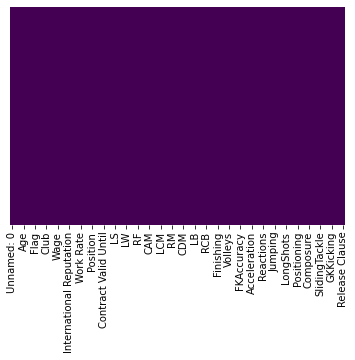

In [17]:
sns.heatmap(df.isna(), cmap='viridis', yticklabels=False, cbar=None)

In [18]:
# Funkcija koja vrsi skaliranje promenljivih zeljenom metodom

def feature_scaling(df, features, method):
    
    for feature in features:
        scaled_feature = method.fit_transform(df[[feature]])
        df[feature] = scaled_feature
        
feature_scaling(df, numeric, MinMaxScaler())

df[numeric].head()

,Unnamed: 0,ID,Age,Overall,Potential,Special,International Reputation,Weak Foot,Skill Moves,Jersey Number,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,0.000000,0.640732,0.517241,1.000000,0.978723,0.910836,1.00,0.75,0.75,0.091837,...,0.804598,1.000000,0.329670,0.285714,0.261364,0.056180,0.109890,0.155556,0.146067,0.075269
1,0.000055,0.084285,0.586207,1.000000,0.978723,0.926935,1.00,0.75,1.00,0.061224,...,0.919540,0.989247,0.274725,0.318681,0.227273,0.067416,0.109890,0.155556,0.146067,0.107527
2,0.000110,0.773933,0.344828,0.958333,0.957447,0.874303,1.00,1.00,1.00,0.091837,...,0.873563,0.978495,0.263736,0.241758,0.340909,0.089888,0.087912,0.155556,0.157303,0.107527
3,0.000165,0.782891,0.379310,0.937500,0.957447,0.458204,0.75,0.50,0.00,0.000000,...,0.402299,0.698925,0.131868,0.208791,0.113636,1.000000,0.923077,0.955556,0.977528,1.000000
4,0.000220,0.782506,0.379310,0.937500,0.936170,0.959752,0.75,1.00,0.75,0.061224,...,0.850575,0.913978,0.714286,0.615385,0.545455,0.157303,0.131868,0.044444,0.101124,0.129032


In [34]:
from collections import Counter

# kmeans = KMeans(n_clusters=3, random_state=0)
# kmeans.fit(df[numeric])
# kmeans.labels_
# count = Counter(kmeans.labels_)
# d = {}
# for value, times in count.most_common():
#     d[value] = times
    
# d

sse = []
silhouette = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df[numeric])
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df[numeric], kmeans.labels_))
    


Text(0, 0.5, 'SSE')

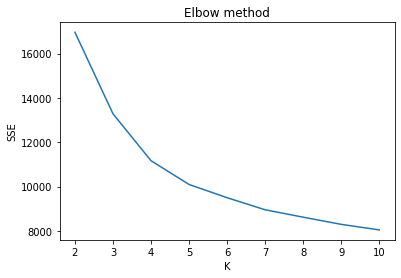

In [35]:
plt.plot(range(2, 11), sse)
plt.title('Elbow method')
plt.xlabel('K')
plt.ylabel('SSE')

Text(0, 0.5, 'Silhouette score')

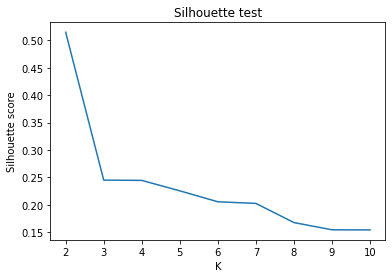

In [36]:
plt.plot(range(2, 11), silhouette)
plt.title('Silhouette test')
plt.xlabel('K')
plt.ylabel('Silhouette score')

In [58]:
categorical_features_index = []
for index, feature in enumerate(df.columns.values):
    if str(df[feature].dtype) == 'object':
        categorical_features_index.append(index)

sse = []
silhouette = []

# for k in range(2, 11):
#     kprototypes = KPrototypes(n_clusters=k, random_state=0)
#     kprototypes.fit(df, categorical=categorical_features_index)
#     sse.append(kprototypes.inertia_)
#     silhouette.append(silhouette_score(df[numeric], kmeans.labels_))
    
# kprototypes = KPrototypes(n_clusters=3, random_state=0)
# kprototypes.fit(df, categorical=categorical_features_index)
# print('Klasteri:')
# print(kprototypes.labels_)

Text(0, 0.5, 'Distance between clusters')

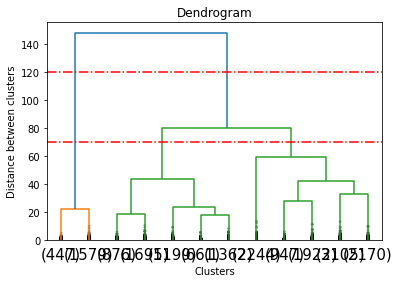

In [74]:
distance_matrix = linkage(df[numeric], 'ward') # .iloc[: 1000, :]
dendrogram(distance_matrix, truncate_mode='lastp', p=12, leaf_font_size=15, show_contracted=True)
plt.axhline(y=120, linestyle='-.', color='red')
plt.axhline(y=70, linestyle='-.', color='red')
plt.title('Dendrogram')
plt.xlabel('Clusters')
plt.ylabel('Distance between clusters')

In [75]:
agglomerative = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agglomerative.fit(df[numeric])
clusters = agglomerative.labels_
count = Counter(clusters)
d = {}
for value, times in count.most_common():
    d[value] = times
d

{0: 16181, 1: 2026}